In [4]:
%load_ext autoreload
%autoreload 2

from ipywidgets import interact, interactive, IntSlider, Layout, RadioButtons
import ipywidgets as widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

import pandas as pd
from ipywidgets import HBox, Label, FloatSlider

style = {'description_width': 'initial'}

def plot_random_walk(n):
    np.random.seed(0)
    n = int(n)
    x = np.linspace(0.0, 10.0, n)
    
    y = np.cumsum(np.random.randn(n))
    print(y[-10:])
    f, ax = plt.subplots(figsize=(8, 6))
    # plt.figure(3, title='Line Chart')
    # plt.figure()
    ax.plot(x, y)
    plt.show()

lb1=Label (value="Play with options and watch the probability space evolve dynamically. \
Remember, smaller the value of $C$, stronger the regularization strength",fontsize=15)

logp=interactive(plot_random_walk,n=FloatSlider(value=10, min=0, max=1000, step=10,
                                       description='number of dots', style=style, continuous_update=True))

# Set the height of the control.children[-1] so that the output does not jump and flicker
output = logp.children[-1]
output.layout.height = '500px'
output.layout.width = '1000px'

display(lb1)
display(logp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Label(value='Play with options and watch the probability space evolve dynamically. Remember, smaller the value of $C$, stronger the regularization strength')

interactive(children=(FloatSlider(value=10.0, description='number of dots', max=1000.0, step=10.0, style=SliderStyle(description_width='initial')), Output(layout=Layout(height='500px', width='1000px'))), _dom_classes=('widget-interact',))

In [5]:
import sys
if "'/Users/martin/Projects/tick'" in sys.path:
    sys.path.remove('/Users/martin/Projects/tick')
sys.path = ['/Users/martin/Projects/tick_expe'] + sys.path


In [6]:
from poisson_see_duals import load_dataset, run_solver, load_experiments
from tick.optim.model import ModelPoisReg
from scipy.stats import linregress
from tick.plot import plot_history

import statsmodels.api as sm
import numpy as np

def plot_dual_vs_init(n_samples, n_features, l_l2sq_power, max_iter, init_type):
    l_l2sq = np.power(n_samples, l_l2sq_power)
    dataset = 'simulated_{}_{}'.format(n_samples, n_features)
    features, labels = load_dataset(dataset)
    
    solver = run_solver(dataset, features, labels, l_l2sq, max_iter_sdca=max_iter)
    
    model = ModelPoisReg(fit_intercept=False, link='identity')
    model.fit(features, labels)
    
    duals = load_experiments(dataset, l_l2sq, 'duals')
    print('non zeros labels', sum(labels != 0))
    dual_inits = model.get_dual_init(l_l2sq, init_type=init_type)
    
    non_zero_features = features[labels != 0]
    norms = np.linalg.norm(non_zero_features, axis=1)
    normalized_inits = dual_inits / norms
    normalized_duals = duals / norms
    
    slope, intercept, r_value, p_value, std_err = \
        linregress(normalized_inits, normalized_duals)
    
    f, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(normalized_inits, normalized_duals)
    ax.plot([0, max(normalized_inits)],
                 [intercept, intercept + slope * max(normalized_inits)],
                 color='C1', label='{:.2g} + {:.4g}x'.format(intercept, slope))
    
    linreg_no_interceot = sm.OLS(normalized_duals, normalized_inits)
    slope_no_intercept = linreg_no_interceot.fit().params[0]
    ax.plot([0, max(normalized_inits)],
                 [0, slope_no_intercept * max(normalized_inits)],
                 color='C2', label='{:.4g}x'.format(slope_no_intercept))
    
    ax.plot([0, max(normalized_inits)],
             [0, max(normalized_inits)],
             color='C3', label='x')

    ax.set_ylabel('dual sol / norm')
    ax.set_xlabel('dual init / norm')
    ax.legend()
    plt.show()
    
    f, ax = plt.subplots(figsize=(8, 3))
    solver.history.values['duality_gap'] = [np.abs(x) if np.isfinite(x) else np.nan
                                            for x in solver.history.values['duality_gap']]
    plot_history([solver], log_scale=True, ax=ax, y='duality_gap')

n_samples_slider = IntSlider(value=1000, min=0, max=10000, step=10,
                             description='number of samples', style=style, continuous_update=False)

n_features_slider = IntSlider(value=10, min=0, max=1000, step=1,
                              description='number of features', style=style, continuous_update=False)

max_iter_slider = IntSlider(value=1000, min=10, max=10000, step=10,
                            description='max iterations', style=style, continuous_update=False)

l_l2sq_slider = FloatSlider(value=-0.5, min=-2, max=0, step=0.01,
                            description='Regularization $\\lambda = n^{x}$)', style=style, continuous_update=False)


init_type_radio = RadioButtons(options=['psi', 'features'], description='Init type')
    
dual_vs_init = interactive(plot_dual_vs_init,
                           n_samples=n_samples_slider, n_features=n_features_slider,
                           l_l2sq_power = l_l2sq_slider, max_iter=max_iter_slider,
                          init_type=init_type_radio)

# Set the height of the control.children[-1] so that the output does not jump and flicker
output = dual_vs_init.children[-1]
output.layout.height = '1000px'
output.layout.width = '800px'

display(dual_vs_init)

interactive(children=(IntSlider(value=1000, continuous_update=False, description='number of samples', max=10000, step=10, style=SliderStyle(description_width='initial')), IntSlider(value=10, continuous_update=False, description='number of features', max=1000, style=SliderStyle(description_width='initial')), FloatSlider(value=-0.5, continuous_update=False, description='Regularization $\\lambda = n^{x}$)', max=0.0, min=-2.0, step=0.01, style=SliderStyle(description_width='initial')), IntSlider(value=1000, continuous_update=False, description='max iterations', max=10000, min=10, step=10, style=SliderStyle(description_width='initial')), RadioButtons(description='Init type', options=('psi', 'features'), value='psi'), Output(layout=Layout(height='1000px', width='800px'))), _dom_classes=('widget-interact',))

In [7]:
# Do the same with real datasets
# Put some sparsity
# check max dual vs dual init

In [137]:
from poisson_see_duals import load_dataset, run_solver, load_experiments
from tick.optim.model import ModelPoisReg
from scipy.stats import linregress
from tick.plot import plot_history

import statsmodels.api as sm
import numpy as np

sdca_list = [None]

def plot_dual_vs_init(dataset, n_samples, n_features, l_l2sq_power, max_iter, init_type):
    dataset = '{}_{}'.format(dataset, n_samples)
    features, labels = load_dataset(dataset)
    features = np.ascontiguousarray(features[:n_samples, :n_features])
    labels = labels[:n_samples]
    # labels[labels > 20] = 20
    
    n_samples, n_features = features.shape
    
    print('features shape', features.shape, 'non zeros labels', sum(labels != 0))
    
    l_l2sq = np.power(n_samples, l_l2sq_power)
    
    solver = run_solver(dataset, features, labels, l_l2sq, max_iter_sdca=max_iter)
    
    model = ModelPoisReg(fit_intercept=False, link='identity')
    model.fit(features, labels)
    
    duals = load_experiments(dataset, l_l2sq, 'duals')
    dual_inits = model.get_dual_init(l_l2sq, init_type=init_type)
    
    non_zero_features = features[labels != 0]
    norms = np.linalg.norm(non_zero_features, axis=1)
    normalized_inits = dual_inits / norms
    normalized_duals = duals / norms
    
    slope, intercept, r_value, p_value, std_err = \
        linregress(normalized_inits, normalized_duals)
    
    f, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(normalized_inits, normalized_duals, c=labels[labels != 0], cmap='jet')
    ax.plot([0, max(normalized_inits)],
                 [intercept, intercept + slope * max(normalized_inits)],
                 color='C1', label='{:.2g} + {:.4g}x'.format(intercept, slope))
    plt.colorbar(sc)
    
    linreg_no_interceot = sm.OLS(normalized_duals, normalized_inits)
    slope_no_intercept = linreg_no_interceot.fit().params[0]
    ax.plot([0, max(normalized_inits)],
                 [0, slope_no_intercept * max(normalized_inits)],
                 color='C2', label='{:.4g}x'.format(slope_no_intercept))
    
    ax.plot([0, max(normalized_inits)],
             [0, max(normalized_inits)],
             color='C3', label='x')

    ax.set_ylabel('dual sol / norm')
    ax.set_xlabel('dual init / norm')
    ax.legend()
    plt.show()
    
    f, axes = plt.subplots(1, 2, figsize=(8, 3))
    solver.history.values['duality_gap'] = [np.abs(x) if np.isfinite(x) else np.nan
                                            for x in solver.history.values['duality_gap']]
    plot_history([solver], log_scale=True, ax=axes[0], y='duality_gap')
    
    axes[1].hist(labels[labels != 0])
    sdca_list[0] = solver

dataset_radio = RadioButtons(options=['wine', 'facebook', 'crime', 'vegas', 'news', 'blog', 'simulated'], 
                             description='Dataset', value='crime')    
    
n_samples_slider = IntSlider(value=5000, min=0, max=10000, step=10,
                             description='number of samples', style=style, continuous_update=False)

n_features_slider = IntSlider(value=100, min=0, max=1000, step=1,
                              description='number of features', style=style, continuous_update=False)

max_iter_slider = IntSlider(value=1000, min=10, max=10000, step=10,
                            description='max iterations', style=style, continuous_update=False)

l_l2sq_slider = FloatSlider(value=-0.5, min=-2, max=0, step=0.01,
                            description='Regularization $\\lambda = n^{x}$)', style=style, continuous_update=False)

init_type_radio = RadioButtons(options=['psi', 'features', 'sqrt', 'log'], description='Init type')
    
dual_vs_init = interactive(plot_dual_vs_init, dataset=dataset_radio,
                           n_samples=n_samples_slider, n_features=n_features_slider,
                           l_l2sq_power = l_l2sq_slider, max_iter=max_iter_slider,
                          init_type=init_type_radio)

# Set the height of the control.children[-1] so that the output does not jump and flicker
output = dual_vs_init.children[-1]
output.layout.height = '1000px'
output.layout.width = '800px'

display(dual_vs_init)

interactive(children=(RadioButtons(description='Dataset', index=2, options=('wine', 'facebook', 'crime', 'vegas', 'news', 'blog', 'simulated'), value='crime'), IntSlider(value=5000, continuous_update=False, description='number of samples', max=10000, step=10, style=SliderStyle(description_width='initial')), IntSlider(value=100, continuous_update=False, description='number of features', max=1000, style=SliderStyle(description_width='initial')), FloatSlider(value=-0.5, continuous_update=False, description='Regularization $\\lambda = n^{x}$)', max=0.0, min=-2.0, step=0.01, style=SliderStyle(description_width='initial')), IntSlider(value=1000, continuous_update=False, description='max iterations', max=10000, min=10, step=10, style=SliderStyle(description_width='initial')), RadioButtons(description='Init type', options=('psi', 'features', 'sqrt', 'log'), value='psi'), Output(layout=Layout(height='1000px', width='800px'))), _dom_classes=('widget-interact',))

In [111]:
sdca = sdca_list[0]
# sdca.solution

In [112]:
features, labels = sdca.model.features, sdca.model.labels
non_zero_features = features[labels != 0]
non_zero_labels = labels[labels != 0]

norms = np.linalg.norm(non_zero_features, axis=1)
dual_inits = sdca.model.get_dual_init(sdca.l_l2sq, init_type='psi')
normalized_dual = sdca.dual_solution / norms
normalized_dual_inits = dual_inits / norms

coeffs = normalized_dual / normalized_dual_inits
top_left = np.argmax(coeffs)
top_lefts = np.argsort(coeffs)[::-1][:5]

mask = normalized_dual_inits > 40
good_duals = normalized_dual.copy()
good_duals[coeffs > 3] = 0 
top_right = np.argsort(good_duals)[::-1][:5]

psi = np.mean(features, axis=0)
psi.dot(non_zero_features[top_lefts[0]])

mean_sum_x = np.mean(non_zero_features, axis=0)
mean_sum_yx = np.mean((non_zero_features.T * non_zero_labels).T, axis=0)

In [113]:
import pandas as pd
df = pd.DataFrame(columns=['g', 'coeffs', 'dual', 'init', 
                           'sum x T x', 'sum yx T x', 'psi T x', 'w T x', '|x|', 'y',
                          'y log(w T x)'])

for index in np.hstack((top_lefts, top_right)):
    x = non_zero_features[index]
    if index in top_lefts:
        name = 'bad'
    else:
        name = 'good'
    df = df.append({'g': name,
                    'coeffs': coeffs[index], 
                    'dual': sdca.dual_solution[index],
                    'init': dual_inits[index],
                    'sum x T x': mean_sum_x.dot(x),
                    'sum yx T x': mean_sum_yx.dot(x),
                    'psi T x': psi.dot(x),
                    'w T x': sdca.solution.dot(x),
                    '|x|': np.linalg.norm(x),
                    'y': labels[labels != 0][index],
                    'y log(w T x)': - labels[labels != 0][index] * np.log(sdca.solution.dot(x)),
                   }, ignore_index=True)
df

,g,coeffs,dual,init,sum x T x,sum yx T x,psi T x,w T x,|x|,y,y log(w T x)
0,bad,493.248796,58.272506,0.118140,9.584986,117.076596,10.125891,0.017161,3.473623,1.0,4.065131
1,bad,319.338989,38.139255,0.119432,9.633879,117.775218,10.016377,0.026220,3.443264,1.0,3.641244
2,bad,146.165552,16.850960,0.115287,9.781234,118.462843,10.376510,0.059344,3.849918,1.0,2.824408
3,bad,86.481297,9.862789,0.114045,9.925757,122.054456,10.489466,0.101391,3.611412,1.0,2.288769
4,bad,84.962101,9.496201,0.111770,10.139318,123.936655,10.703018,0.105305,3.698295,1.0,2.250892
5,good,0.380776,20.530145,53.916629,9.160642,145.062637,8.764059,19.240000,3.491539,395.0,-1168.011631
6,good,0.361926,21.254190,58.725276,9.621053,154.187969,9.248296,21.360494,3.751835,454.0,-1389.940587
7,good,0.422303,16.077999,38.072193,10.200133,157.447194,9.960526,19.716384,3.805499,317.0,-945.119639
8,good,0.840695,12.054656,14.338910,10.159831,142.539471,10.178285,10.120571,3.382367,122.0,-282.377547
9,good,0.959723,10.358715,10.793443,10.187295,142.109112,10.085846,8.784873,3.418228,91.0,-197.745847


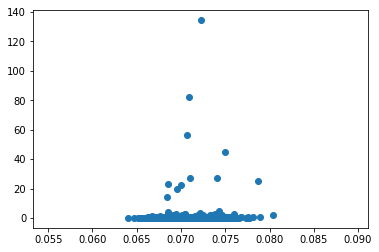

In [46]:
norms = np.linalg.norm(non_zero_features, axis=1)

#plt.scatter(normalized_dual, 1 / psi.dot(non_zero_features.T))
# plt.scatter(non_zero_labels, normalized_dual)
#plt.scatter(1 / psi.dot(non_zero_features.T), normalized_dual / non_zero_labels)
plt.scatter(1 / np.sqrt(mean_sum_yx.dot(non_zero_features.T)), sdca.dual_solution / non_zero_labels)

In [132]:
generators, results = find_generators(non_zero_features[:, :10])

0
50
100
150
200
250


In [134]:
results[0]

     fun: 0.17813300877595784
 message: 'Optimization failed. Unable to find a feasible starting point.'
     nit: 19
  status: 2
 success: False
       x: nan

In [135]:
generators

array([ True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,

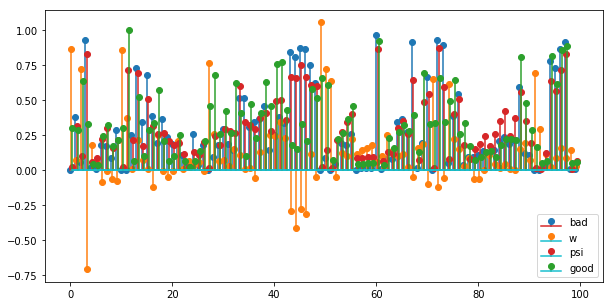

In [45]:
plt.figure(figsize=(10, 5))

def get_x(count):
    return np.arange(len(features.T)) + 0.15 * count

count = 0
plt.stem(get_x(count), non_zero_features[top_left], label='bad')
count += 1

plt.stem(np.arange(len(features.T)) + 0.2, sdca.solution / 3, basefmt='C9',
         linefmt='C1', markerfmt='C1o', label='w')
count += 1

plt.stem(get_x(count), psi, basefmt='C9',
         linefmt='C3', markerfmt='C3o', label='psi')
count += 1

plt.stem(get_x(count), non_zero_features[top_right],
         basefmt='C9', linefmt='C2', markerfmt='C2o', label='good')
count += 1

plt.legend()

In [46]:
print(psi.dot(non_zero_features[top_right]), psi.dot(non_zero_features[top_left]))
print(np.linalg.norm(non_zero_features[top_right]), np.linalg.norm(non_zero_features[top_left]))

13.290033044592548 14.80203099275123
4.053119865420396 4.077269327207222


In [47]:
normalized_dual_inits[top_right], normalized_dual_inits[top_left]

(16.512969529309977, 0.03731237409320273)

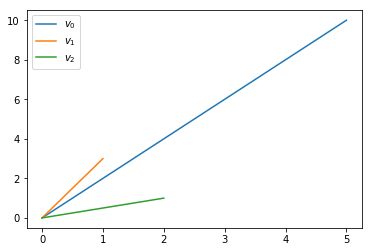

In [91]:
vectors = np.array([
    [5, 10],
    [1, 3],
    [2, 1],
])
for i, vector in enumerate(vectors):
    plt.plot([0, vector[0]], [0, vector[1]], label='$v_{}$'.format(i))

#plt.plot([0, 3 * vectors[1, 0]], [0, 3 * vectors[1, 1]])
    
plt.legend()

In [131]:
from scipy.optimize import linprog


def find_generators(vectors):
    n, d = vectors.shape

    kept_mask = np.ones(n, dtype=bool)
    results = []
    for i in range(n):
        if i % 50 == 0:
            print(i)
        
        c = np.zeros(n - 1)

        vectors_j = vectors[np.arange(n) != i]
        A = vectors_j.T
        b = vectors[i]

        res = linprog(c, A_eq=A, b_eq=b, bounds=(0, None),
                      options={"disp": False, "maxiter": 100})

        if res.success:
            kept_mask[i] = False
        
        results += [res]

    return kept_mask, results

In [119]:
find_generators(vectors)

0


array([False,  True,  True])